In [42]:
#most positive, most negative, largest range, biggest reversal

# Load necessary libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler



In [43]:
# File path to the Excel file
file_path = "data.xlsx"  # Replace with your actual file path

# Load the Excel file into a dictionary of DataFrames
try:
    # Read all sheets into a dictionary of DataFrames
    excel_data = pd.read_excel(os.path.join(os.getcwd(), "data", file_path), sheet_name=None)
    print("Excel file successfully loaded!")
    
    # Access specific sheets by name
    df_oct = excel_data.get("oct", pd.DataFrame())
    df_jan = excel_data.get("jan", pd.DataFrame())
    df_jan_summary = excel_data.get("jan_summary", pd.DataFrame())
    df_oct_summary = excel_data.get("oct_summary", pd.DataFrame())

except FileNotFoundError:
    print(f"File not found: {file_path}. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

# Combine the two DataFrames
df_combined = pd.concat([df_jan_summary, df_oct_summary], ignore_index=True)

# Create a DataFrame for rows with NaN values
exemption_list = df_combined[df_combined.isnull().any(axis=1)]

# Drop rows with NaN values from the combined DataFrame
df_combined = df_combined.dropna()

Excel file successfully loaded!


In [44]:
# Assuming 'df' is your DataFrame
columns_to_average = [
    "Reversal_Frequency",
    "Average_Return",
    "Max_Positive_Return",
    "Max_Negative_Return",
    "Forward_1D_Return_Avg",
    "Forward_2D_Return_Avg",
    "Forward_3D_Return_Avg",
    "Forward_4D_Return_Avg",
    "Forward_5D_Return_Avg",
    "Two_Day_Reversal_Return_Avg"
]

# Group by 'anonymous signal' and calculate the mean for the specified columns
df_combined_avg = (
    df_combined.groupby("anonymous signal", as_index=False)[columns_to_average].mean()
)

# Optionally handle the 'Ticker' column, for example by concatenating unique tickers for each signal
df_combined_avg["Ticker"] = (
    df_combined.groupby("anonymous signal")["Ticker"]
    .apply(lambda x: ', '.join(x.unique()))  # Concatenate unique tickers
    .reset_index(drop=True)
)


In [45]:
# List of columns to apply clustering (excluding Ticker and any non-numeric columns)
columns_to_cluster = [
    "Reversal_Frequency",
    "Average_Return",
    "Max_Positive_Return",
    "Max_Negative_Return",
    "Forward_1D_Return_Avg",
    "Forward_2D_Return_Avg",
    "Forward_3D_Return_Avg",
    "Forward_4D_Return_Avg",
    "Forward_5D_Return_Avg",
    "Two_Day_Reversal_Return_Avg"
]

# Define bin labels
cluster_labels = ["low", "med", "high"]

# Perform KMeans clustering for each column
for column in columns_to_cluster:
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_combined_avg[f"{column}_Cluster"] = kmeans.fit_predict(df_combined_avg[[column]])
    
    # Sort clusters by their centroids
    centroids = kmeans.cluster_centers_.flatten()
    sorted_clusters = np.argsort(centroids)
    
    # Map clusters to bin labels
    cluster_to_bin = {sorted_clusters[i]: cluster_labels[i] for i in range(len(cluster_labels))}
    df_combined_avg[f"{column}_bin"] = df_combined_avg[f"{column}_Cluster"].map(cluster_to_bin)
    
    # Drop intermediate cluster column if not needed
    df_combined_avg.drop(columns=[f"{column}_Cluster"], inplace=True)


In [46]:
# Ensure non-numeric columns are excluded
numeric_columns = df_combined_avg.select_dtypes(include=["number"])

# Calculate short-term and long-term trends 
df_combined_avg["Short_MA"] = numeric_columns["Average_Return"].rolling(window=3).mean()
df_combined_avg["Long_MA"] = numeric_columns["Average_Return"].rolling(window=10).mean()

# Identify trend changes
df_combined_avg["Trend_Change"] = (df_combined_avg["Short_MA"] > df_combined_avg["Long_MA"]).astype(int)

# Correlation with trend changes
# trend_corr = numeric_columns.corr()["Trend_Change"].sort_values(ascending=False)

# Forward fill and backward fill Short_MA and Long_MA without inplace
df_combined_avg["Short_MA"] = df_combined_avg["Short_MA"].ffill().bfill()
df_combined_avg["Long_MA"] = df_combined_avg["Long_MA"].ffill().bfill()


In [47]:
df_combined_avg

,anonymous signal,Reversal_Frequency,Average_Return,Max_Positive_Return,Max_Negative_Return,Forward_1D_Return_Avg,Forward_2D_Return_Avg,Forward_3D_Return_Avg,Forward_4D_Return_Avg,Forward_5D_Return_Avg,...,Max_Negative_Return_bin,Forward_1D_Return_Avg_bin,Forward_2D_Return_Avg_bin,Forward_3D_Return_Avg_bin,Forward_4D_Return_Avg_bin,Forward_5D_Return_Avg_bin,Two_Day_Reversal_Return_Avg_bin,Short_MA,Long_MA,Trend_Change
0,8,2.000000,2.315000,2.500000,2.130000,3.355000,7.765000,11.515000,10.600000,16.155000,...,high,high,high,high,high,high,high,-2.217407,-1.573109,0
1,10,1.000000,-3.696667,-3.696667,-3.696667,0.926667,4.290000,5.176667,5.140000,6.783333,...,med,med,med,med,med,med,high,-2.217407,-1.573109,0
2,12,2.333333,-5.270556,-3.296667,-7.400000,0.277778,2.676111,4.296667,4.076667,6.242778,...,med,med,med,med,med,med,high,-2.217407,-1.573109,0
3,13,1.000000,-0.440000,-0.440000,-0.440000,2.360000,1.710000,3.060000,3.340000,3.000000,...,high,med,low,low,low,low,high,-3.135741,-1.573109,0
4,14,4.000000,-2.160000,-0.320000,-5.870000,1.720000,1.402500,2.667500,2.080000,2.240000,...,med,med,low,low,low,low,high,-2.623519,-1.573109,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,138,1.000000,15.150000,15.150000,15.150000,-3.420000,11.710000,7.750000,3.410000,3.100000,...,high,low,high,high,low,low,high,6.733333,3.095303,1
128,139,1.000000,12.580000,23.130000,2.030000,-2.940000,-1.840000,1.820000,-1.220000,2.030000,...,high,low,low,low,low,low,low,10.173333,4.437926,1
129,140,2.000000,-3.115000,0.200000,-6.430000,0.935000,0.720000,2.215000,2.050000,2.335000,...,med,med,low,low,low,low,high,8.205000,3.980658,1
130,144,1.000000,6.900000,6.900000,6.900000,3.940000,6.700000,9.030000,11.910000,15.380000,...,high,high,high,high,high,high,low,5.455000,4.693848,1



Analyzing: Forward_1D_Return_Avg

Variance Inflation Factor (VIF):
                       Feature        VIF
0             anonymous signal   3.222535
1           Reversal_Frequency   2.274026
2               Average_Return  10.235574
3          Max_Positive_Return  12.703321
4          Max_Negative_Return   6.724016
5  Two_Day_Reversal_Return_Avg   1.269885

Linear Regression Coefficients:
                       Feature  Coefficient
4          Max_Negative_Return     0.118204
3          Max_Positive_Return     0.109063
1           Reversal_Frequency    -0.003026
0             anonymous signal    -0.009297
2               Average_Return    -0.085766
5  Two_Day_Reversal_Return_Avg    -0.663562
Linear Model R-squared: 0.29683448105920396
Linear Model Mean Squared Error: 6.039179580339078

Lasso Regression Feature Importance:
                       Feature  Coefficient
3          Max_Positive_Return     1.483443
4          Max_Negative_Return     0.724236
1           Reversal_Frequency  

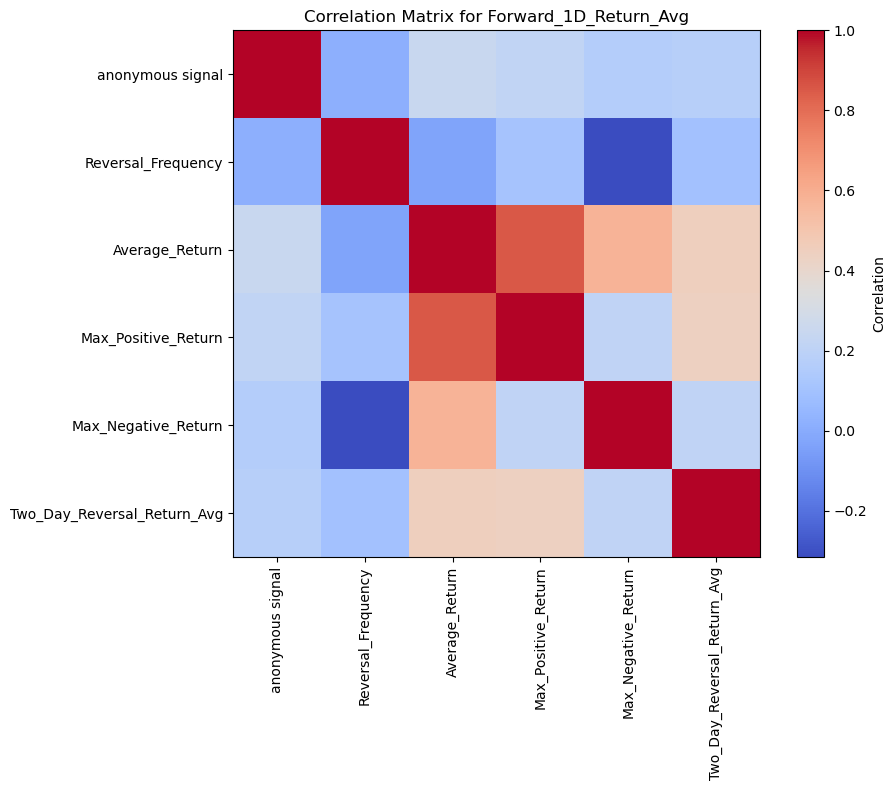




Analyzing: Forward_2D_Return_Avg

Variance Inflation Factor (VIF):
                       Feature        VIF
0             anonymous signal   3.222535
1           Reversal_Frequency   2.274026
2               Average_Return  10.235574
3          Max_Positive_Return  12.703321
4          Max_Negative_Return   6.724016
5  Two_Day_Reversal_Return_Avg   1.269885

Linear Regression Coefficients:
                       Feature  Coefficient
4          Max_Negative_Return     0.232074
3          Max_Positive_Return     0.221271
1           Reversal_Frequency    -0.008578
0             anonymous signal    -0.014952
2               Average_Return    -0.169319
5  Two_Day_Reversal_Return_Avg    -1.190444
Linear Model R-squared: 0.36904025358672066
Linear Model Mean Squared Error: 17.730397496789905

Lasso Regression Feature Importance:
                       Feature  Coefficient
3          Max_Positive_Return     3.187151
4          Max_Negative_Return     1.510332
1           Reversal_Frequenc

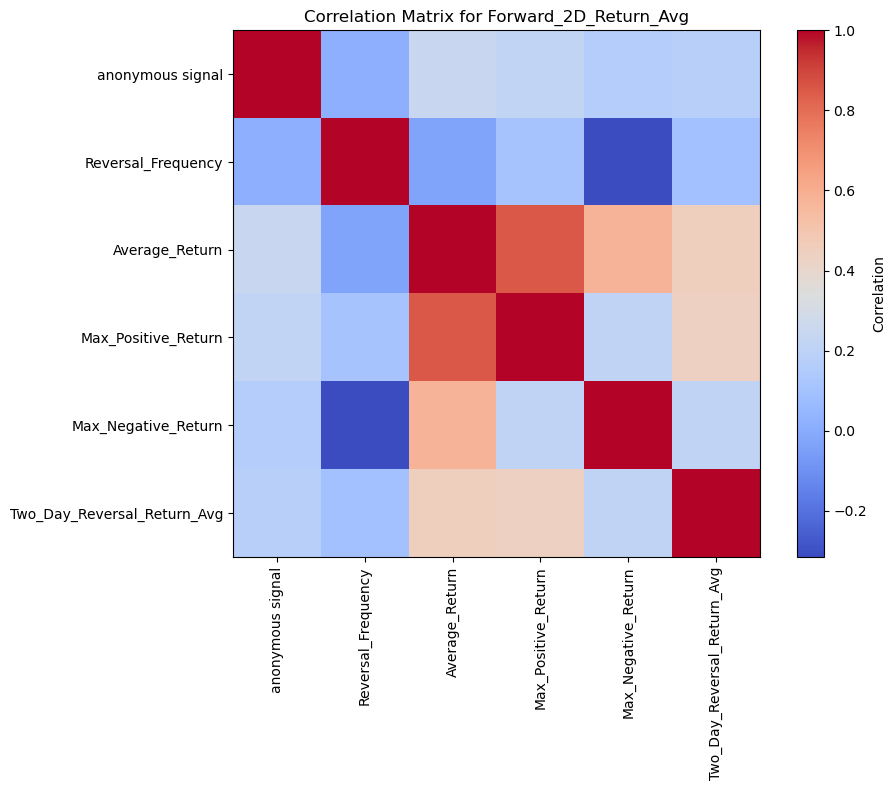




Analyzing: Forward_3D_Return_Avg

Variance Inflation Factor (VIF):
                       Feature        VIF
0             anonymous signal   3.222535
1           Reversal_Frequency   2.274026
2               Average_Return  10.235574
3          Max_Positive_Return  12.703321
4          Max_Negative_Return   6.724016
5  Two_Day_Reversal_Return_Avg   1.269885

Linear Regression Coefficients:
                       Feature  Coefficient
4          Max_Negative_Return     0.325307
3          Max_Positive_Return     0.314128
1           Reversal_Frequency    -0.012926
0             anonymous signal    -0.026900
2               Average_Return    -0.196311
5  Two_Day_Reversal_Return_Avg    -1.488723
Linear Model R-squared: 0.4342165868094464
Linear Model Mean Squared Error: 24.589477613288835

Lasso Regression Feature Importance:
                       Feature  Coefficient
3          Max_Positive_Return     4.597036
4          Max_Negative_Return     2.153949
1           Reversal_Frequency

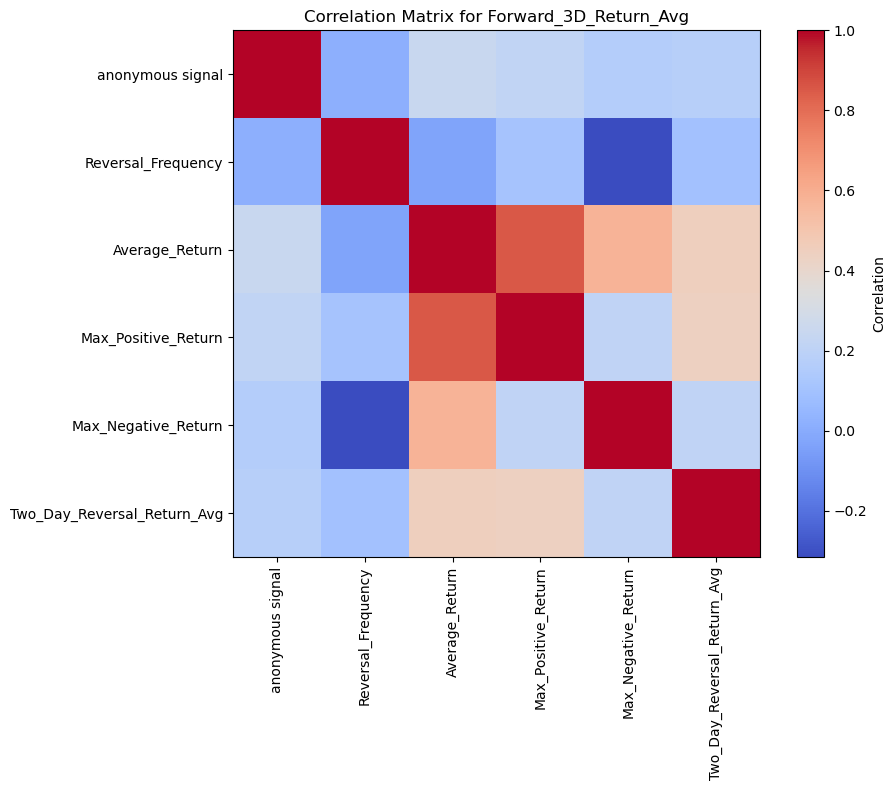




Analyzing: Forward_4D_Return_Avg

Variance Inflation Factor (VIF):
                       Feature        VIF
0             anonymous signal   3.222535
1           Reversal_Frequency   2.274026
2               Average_Return  10.235574
3          Max_Positive_Return  12.703321
4          Max_Negative_Return   6.724016
5  Two_Day_Reversal_Return_Avg   1.269885

Linear Regression Coefficients:
                       Feature  Coefficient
4          Max_Negative_Return     0.453107
3          Max_Positive_Return     0.438484
1           Reversal_Frequency    -0.013603
0             anonymous signal    -0.035544
2               Average_Return    -0.292090
5  Two_Day_Reversal_Return_Avg    -1.827306
Linear Model R-squared: 0.4548274855771036
Linear Model Mean Squared Error: 43.373198862575634

Lasso Regression Feature Importance:
                       Feature  Coefficient
3          Max_Positive_Return     6.485290
4          Max_Negative_Return     3.036268
1           Reversal_Frequency

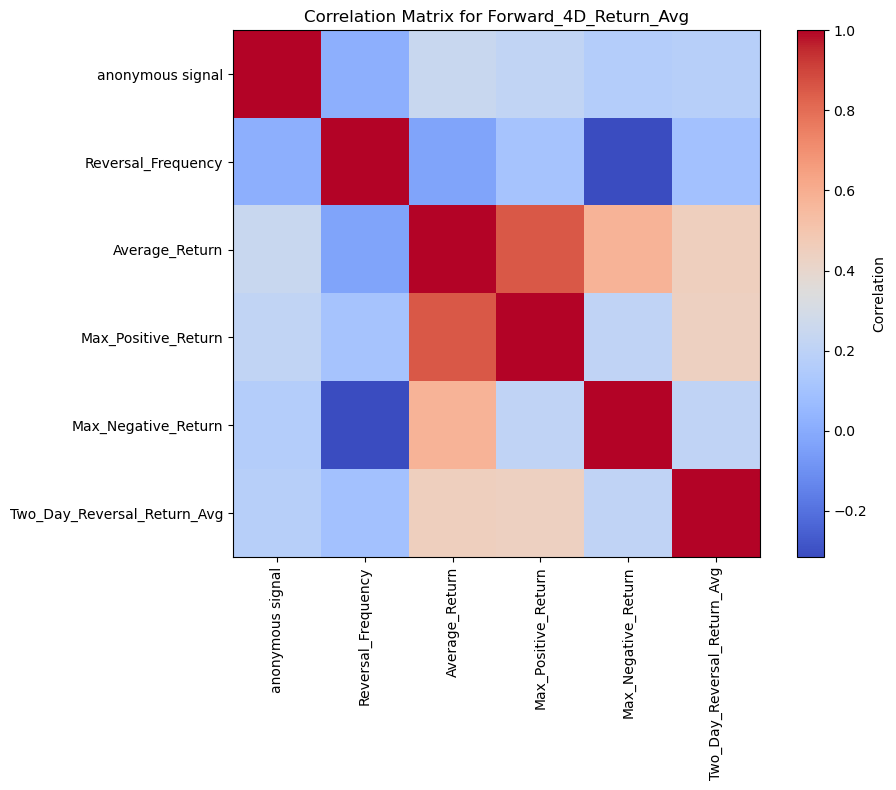




Analyzing: Forward_5D_Return_Avg

Variance Inflation Factor (VIF):
                       Feature        VIF
0             anonymous signal   3.222535
1           Reversal_Frequency   2.274026
2               Average_Return  10.235574
3          Max_Positive_Return  12.703321
4          Max_Negative_Return   6.724016
5  Two_Day_Reversal_Return_Avg   1.269885

Linear Regression Coefficients:
                       Feature  Coefficient
4          Max_Negative_Return     0.558356
3          Max_Positive_Return     0.543696
1           Reversal_Frequency    -0.016065
0             anonymous signal    -0.047552
2               Average_Return    -0.402188
5  Two_Day_Reversal_Return_Avg    -1.809759
Linear Model R-squared: 0.45697146590796267
Linear Model Mean Squared Error: 57.26535689648046

Lasso Regression Feature Importance:
                       Feature  Coefficient
3          Max_Positive_Return     8.082776
4          Max_Negative_Return     3.762840
1           Reversal_Frequency

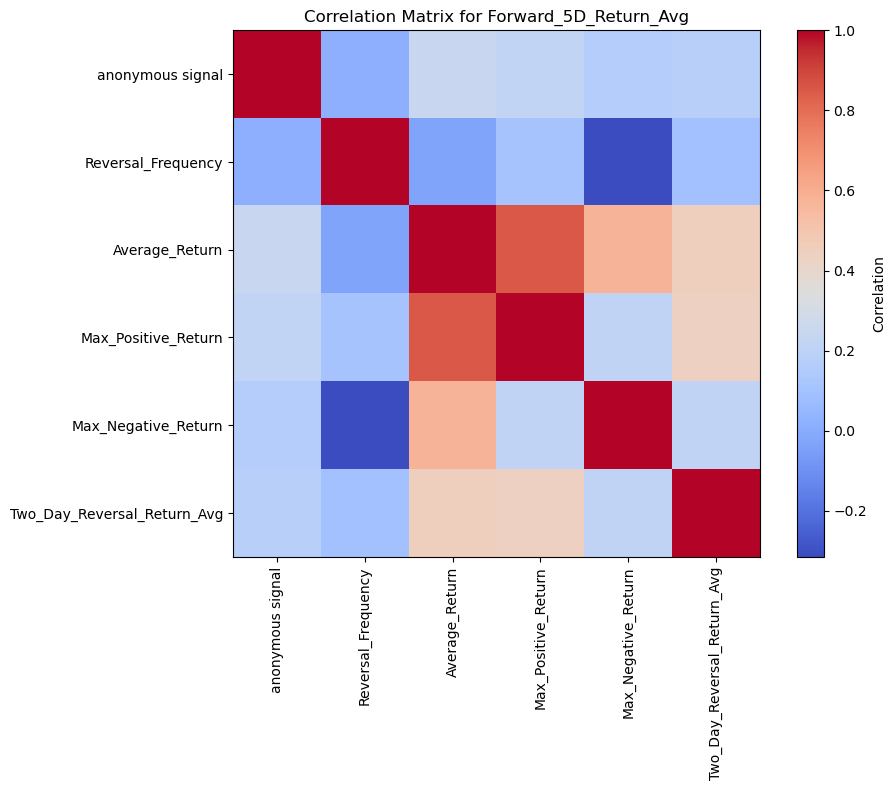

In [48]:
# Define return columns and ignore strategy
return_columns = [
    'Forward_1D_Return_Avg',
    'Forward_2D_Return_Avg',
    'Forward_3D_Return_Avg',
    'Forward_4D_Return_Avg',
    'Forward_5D_Return_Avg'
]

for dependent_var in return_columns:
    # Define columns to ignore
    ignore = [col for col in return_columns if col != dependent_var]

    print(f"\n{'='*50}")
    print(f"Analyzing: {dependent_var}")
    print(f"{'='*50}")

    # Step 1: Define independent variables
    independent_vars = [
        col for col in df_combined.columns
        if col not in [dependent_var, 'Ticker'] and '_bin' not in col and col not in ignore
    ]

    # Step 2: Calculate VIF
    print("\nVariance Inflation Factor (VIF):")
    X = df_combined[independent_vars]
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

    # Step 3: Correlation Table
    corr_table = X.corr()

    # Step 4: Linear Regression
    y = df_combined[dependent_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)

    print("\nLinear Regression Coefficients:")
    coefficients = pd.DataFrame({
        'Feature': independent_vars,
        'Coefficient': linear_model.coef_
    }).sort_values(by='Coefficient', ascending=False)
    print(coefficients)

    # Step 5: Evaluate Linear Model
    y_pred_linear = linear_model.predict(X_test)
    r2_linear = r2_score(y_test, y_pred_linear)
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    print(f"Linear Model R-squared: {r2_linear}")
    print(f"Linear Model Mean Squared Error: {mse_linear}")

    # Step 6: Lasso Regression
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    lasso = Lasso(alpha=0.01)  # Adjust alpha for stronger/weaker regularization
    lasso.fit(X_train_scaled, y_train_scaled)

    print("\nLasso Regression Feature Importance:")
    importance = pd.DataFrame({
        "Feature": independent_vars,
        "Coefficient": lasso.coef_
    }).sort_values(by="Coefficient", ascending=False)
    print(importance)

    # Step 7: Evaluate Lasso Model
    y_pred_lasso = lasso.predict(X_test_scaled)
    r2_lasso = r2_score(y_test_scaled, y_pred_lasso)
    mse_lasso = mean_squared_error(y_test_scaled, y_pred_lasso)
    print(f"Lasso Model R-squared: {r2_lasso}")
    print(f"Lasso Model Mean Squared Error: {mse_lasso}")

    # Step 8: Plot Correlation Matrix Heatmap
    plt.figure(figsize=(10, 8))
    plt.title(f"Correlation Matrix for {dependent_var}")
    plt.imshow(corr_table, cmap='coolwarm', interpolation='none')
    plt.colorbar(label="Correlation")
    plt.xticks(range(len(corr_table)), corr_table.columns, rotation=90)
    plt.yticks(range(len(corr_table)), corr_table.columns)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*50 + "\n")
